In [0]:
# get train and test data
!wget -q https://l1nna.com/372/Assignment/A2-3/train.csv 
!wget -q https://l1nna.com/372/Assignment/A2-3/test.csv

In [0]:
# import libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# read training/test data from file and store in variable
xy_train = pd.read_csv('train.csv')
x_test  = pd.read_csv('test.csv')

xy_train.head()
# xy_train.describe()



ERROR! Session/line number was not unique in database. History logging moved to new session 64


,id,rating,review
0,8594,1,Delivers what it promises_This disposable razo...
1,2202,1,Top Coat_The best top coat I have ever used. I...
2,5977,1,Effortless No Heat Curls_You need to start out...
3,2065,1,Silky_Great as a skin smoother. My skin has be...
4,868,1,"If it's good enough for Giada, it's good enoug..."


In [0]:
x = xy_train.review #extract column "review" and save in x
y = xy_train.rating #extract column "rating" and save in y


# define pipeline
# doing the prepoccisng steps:
# CountVectorizer: To tokenize words; 
# TfidTransvormer: term weighting; scale down the impact of tokens that occur very frequently; tdidf means term-frequency times inverse document-frequency
# SVC: Apply Vector Classification;  The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(class_weight='balanced')),
])

# set parameters of estimators which where defined for the pipeline
# Vect:
# max_features: define how many words will be in the dictionary (sorted by their frequency)
# analyzer: use word-n-gram
# tfidf: 
# use_idf: Enable or disable inverse-document-frequency reweighting
parameters = {
    'vect__max_features': [100, 500, 1000, 5000],
    'vect__analyzer': ['word', ],
    'vect__ngram_range': ((1, 1),(1, 2),(2, 3),(2, 2)), # unigrams or bigrams or trigrams etc; (1,2) means unigrams or bigrams
    'tfidf__use_idf': (True, False),
    #'clf__alpha': (0.00001, 0.000001),
}

# define scoring method
scoring = ['f1', 'accuracy']

# define where to split data (for cross validation)
split = int(len(x) * 0.8)

#define grid search (search for hyperparameters) with defined pipeline, parameters, scoring method, and splitting point for cross validation
#number of jobs run in parallel is set to 20
grid_search = GridSearchCV(
    pipeline, parameters, verbose=3, cv=[(np.arange(0, split), np.arange(split, len(x)))], 
    refit='f1', n_jobs=20, scoring=scoring, return_train_score=True)
grid_search.fit(x, y)

Fitting 1 folds for each of 32 candidates, totalling 32 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   4 out of  32 | elapsed:  1.5min remaining: 10.7min
[Parallel(n_jobs=20)]: Done  15 out of  32 | elapsed:  4.4min remaining:  5.0min
[Parallel(n_jobs=20)]: Done  26 out of  32 | elapsed:  5.8min remaining:  1.3min
[Parallel(n_jobs=20)]: Done  32 out of  32 | elapsed:  6.5min finished


GridSearchCV(cv=[(array([   0,    1,    2, ..., 4975, 4976, 4977]),
                  array([4978, 4979, 4980, ..., 6220, 6221, 6222]))],
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
    

0.9596371882086168
tfidf__use_idf: True
vect__analyzer: 'word'
vect__max_features: 1000
vect__ngram_range: (1, 1)


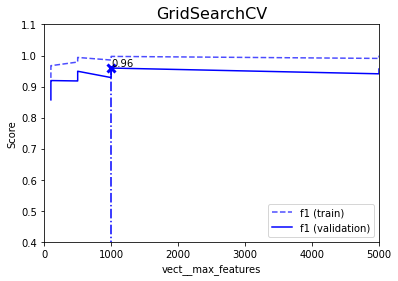

1000.0


In [0]:
# print best score and chosen params
print(grid_search.best_score_)
for param_name in sorted(parameters.keys()):
        print("%s: %r" % (param_name, grid_search.best_params_[param_name]))

# let's visualize hyperparameters against performance

from matplotlib import pyplot as plt

# save max features and results in variables
selected_parameter = 'vect__max_features'
results = grid_search.cv_results_

# create figure with amount features used in dictionary and result
plt.figure()
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel(selected_parameter)
plt.ylabel("Score")


#set range of y-axis in figure
ax = plt.gca()
ax.set_ylim(0.4, 1.1)

ax.set_xlim(0,5000)


# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_'+ selected_parameter].data, dtype=float)

# iterate threw and show f1 score we have for which dictionary size for training and validation set
scorer = 'f1'
color ='b'
for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
    sample_score_mean = [x for _,x in sorted(zip(X_axis,sample_score_mean))]
    ax.plot(sorted(X_axis), sample_score_mean, style, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s)" % (scorer, sample if sample == 'train' else 'validation'))

best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
best_score = results['mean_test_%s' % scorer][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))
    

# add legend and remove grid and then show genetated graph
plt.legend(loc="best")
plt.grid(False)
plt.show()

# ADDED
# shows us that the best dictionary size is 1000 
print(X_axis[best_index])


In [0]:
# generate submission
y_predict = np.squeeze(grid_search.predict(x_test.review))

pd.DataFrame(
    {'id': x_test.id, 'rating':y_predict}).to_csv('sample_submission.csv', index=False)